In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix 


In [3]:
data = pd.read_csv(r"C:\Users\DELL\Desktop\Datasets\heart_2022_no_nans.csv")

data.head()

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,Alabama,Female,Very good,4.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,...,1.60,71.67,27.99,No,No,Yes,Yes,"Yes, received Tdap",No,No
1,Alabama,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,6.0,None of them,No,...,1.78,95.25,30.13,No,No,Yes,Yes,"Yes, received tetanus shot but not sure what type",No,No
2,Alabama,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,"6 or more, but not all",No,...,1.85,108.86,31.66,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes
3,Alabama,Female,Fair,5.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,...,1.70,90.72,31.32,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes
4,Alabama,Female,Good,3.0,15.0,Within past year (anytime less than 12 months ...,Yes,5.0,1 to 5,No,...,1.55,79.38,33.07,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No


In [11]:
# Get the statistical summary of get columns and also round the values down to 2 decimal places
round(data.describe().T, 2)

,count,mean,std,min,25%,50%,75%,max
PhysicalHealthDays,246022.0,4.12,8.41,0.00,0.00,0.00,3.00,30.00
MentalHealthDays,246022.0,4.17,8.10,0.00,0.00,0.00,4.00,30.00
SleepHours,246022.0,7.02,1.44,1.00,6.00,7.00,8.00,24.00
HeightInMeters,246022.0,1.71,0.11,0.91,1.63,1.70,1.78,2.41
WeightInKilograms,246022.0,83.62,21.32,28.12,68.04,81.65,95.25,292.57
BMI,246022.0,28.67,6.51,12.02,24.27,27.46,31.89,97.65


In [12]:
# Selected Features based on domain knowledge
data = data[[
    'State', 'Sex', 'GeneralHealth', 'PhysicalHealthDays', 'MentalHealthDays', 'LastCheckupTime', 'PhysicalActivities', 'SleepHours',
    'SmokerStatus', 'AgeCategory', 'HeightInMeters', 'WeightInKilograms', 'BMI', 'HadDiabetes', 'HadArthritis', 'HadKidneyDisease', 
    'HadAsthma', 'RaceEthnicityCategory', 'HadHeartAttack'
]]

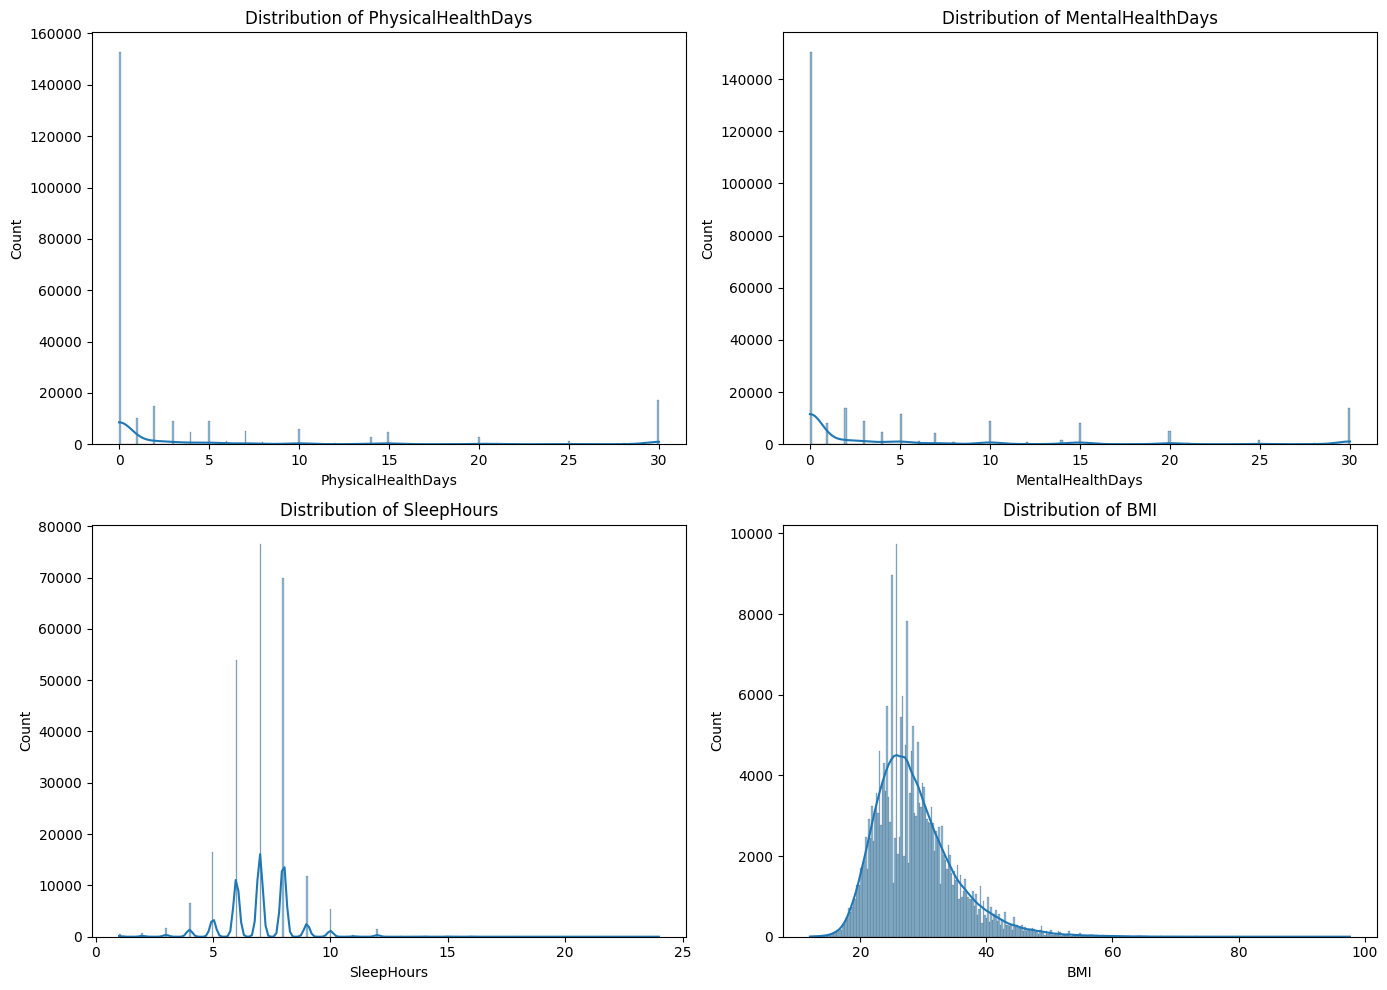

In [13]:
# Plotting histograms for numerical features
numerical_features = ['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'BMI']

plt.figure(figsize=(14, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(2, 2, i + 1)
    sns.histplot(data[feature], kde=True)
    plt.title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

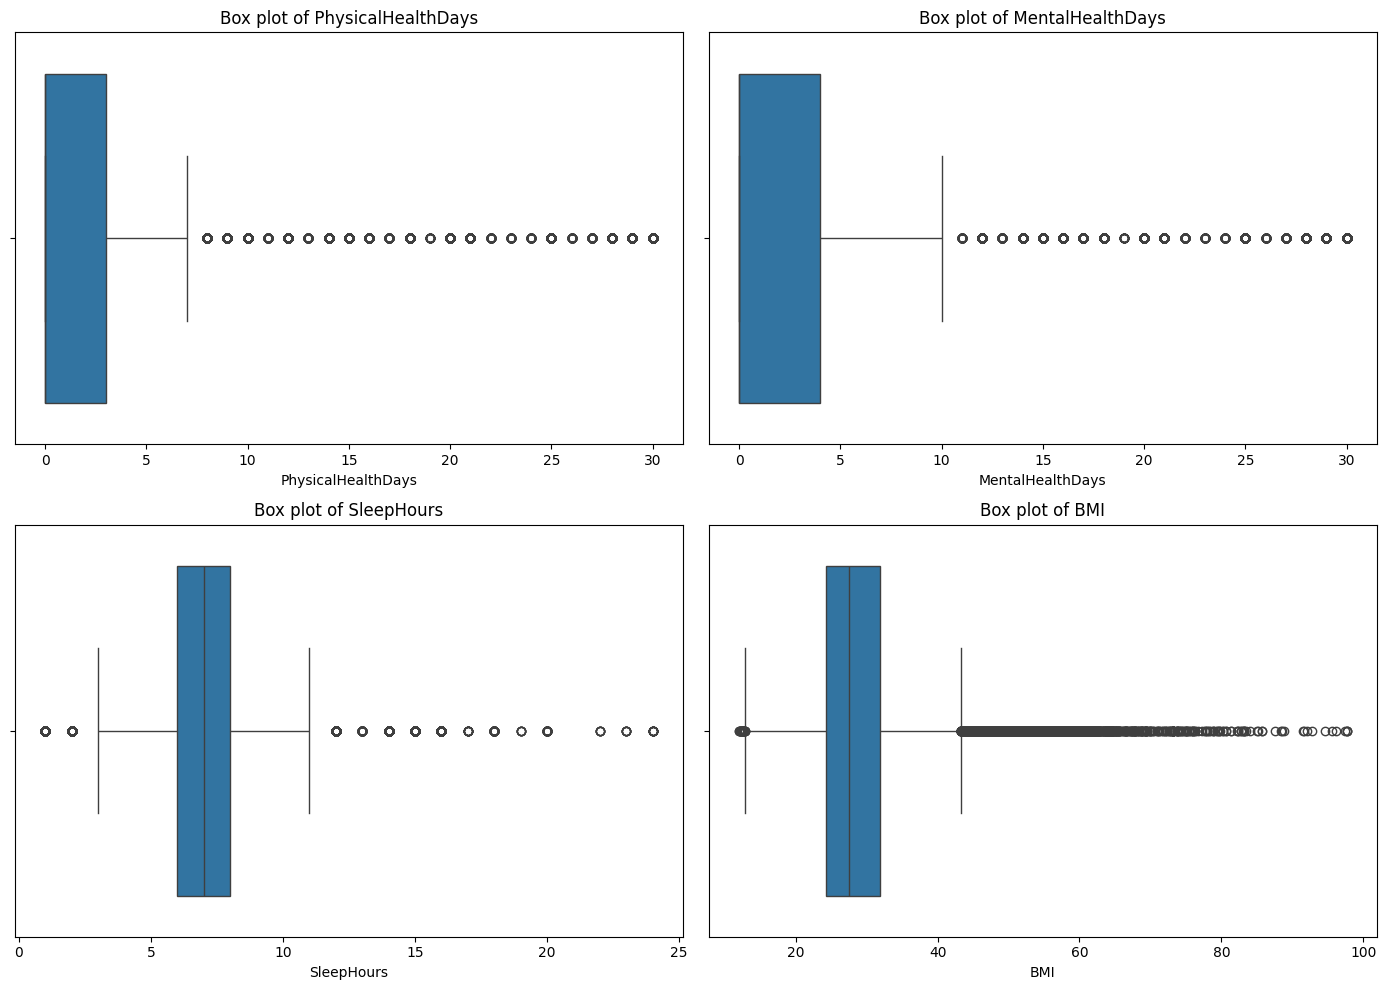

In [14]:
# Plotting box plots for numerical features
plt.figure(figsize=(14, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(x=data[feature])
    plt.title(f'Box plot of {feature}')

plt.tight_layout()
plt.show()


In [15]:
# Detecting and capping outliers using the IQR method
def cap_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return np.clip(series, lower_bound, upper_bound)

for feature in numerical_features:
    data[feature] = cap_outliers(data[feature])


In [16]:
data.head()

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,SmokerStatus,AgeCategory,HeightInMeters,WeightInKilograms,BMI,HadDiabetes,HadArthritis,HadKidneyDisease,HadAsthma,RaceEthnicityCategory,HadHeartAttack
0,Alabama,Female,Very good,4.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,Former smoker,Age 65 to 69,1.60,71.67,27.99,No,Yes,No,No,"White only, Non-Hispanic",No
1,Alabama,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,6.0,Former smoker,Age 70 to 74,1.78,95.25,30.13,Yes,Yes,No,No,"White only, Non-Hispanic",No
2,Alabama,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,Former smoker,Age 75 to 79,1.85,108.86,31.66,No,Yes,No,No,"White only, Non-Hispanic",No
3,Alabama,Female,Fair,5.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,Never smoked,Age 80 or older,1.70,90.72,31.32,No,Yes,No,No,"White only, Non-Hispanic",No
4,Alabama,Female,Good,3.0,10.0,Within past year (anytime less than 12 months ...,Yes,5.0,Never smoked,Age 80 or older,1.55,79.38,33.07,No,Yes,No,No,"White only, Non-Hispanic",No


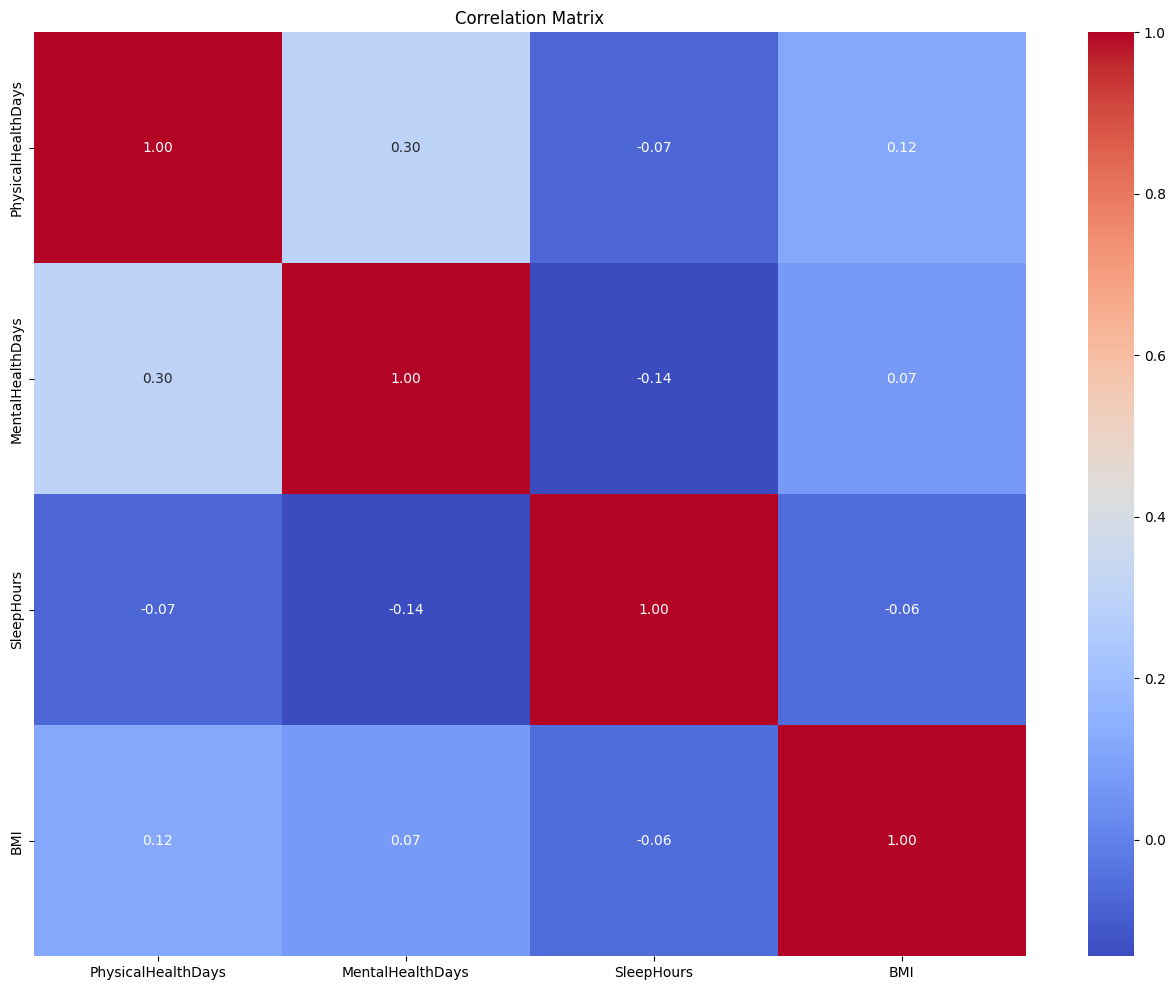

In [17]:
# Correlation matrix
correlation_matrix = data[numerical_features].corr()

# Plotting the heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [18]:
# Feature Engineering 
# create a new feature HealthStatusScore 

data['HealthStatusScore'] = data['PhysicalHealthDays'] + data['MentalHealthDays']

In [19]:
# Define Features and Target 

# Target
target = 'HadHeartAttack'

# Features 
feature_cols = [x for x in data.columns if x != target]

In [20]:
# Categorical columns 
categorical_columns = data[feature_cols].select_dtypes(include=['object']).columns.tolist()

categorical_columns

['State',
 'Sex',
 'GeneralHealth',
 'LastCheckupTime',
 'PhysicalActivities',
 'SmokerStatus',
 'AgeCategory',
 'HadDiabetes',
 'HadArthritis',
 'HadKidneyDisease',
 'HadAsthma',
 'RaceEthnicityCategory']

In [21]:
numerical_features

['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'BMI']

In [22]:
# Define preprocessing pipelines
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first')

In [23]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_columns)
    ])

In [24]:
# Transform the target variable (if necessary)
data[target] = data[target].apply(lambda x: 1 if x == 'Yes' else 0)

In [25]:
data[target].value_counts(normalize=True)

# We have to use the stratified shuffle split because the classes in target variable are inbalanced 

HadHeartAttack
0    0.945391
1    0.054609
Name: proportion, dtype: float64

In [26]:
# Create an instance StratifiedShuffleSplit and define 1500 indexes for the test data 
# This creates a generator
strat_shuff_split = StratifiedShuffleSplit(n_splits=1, test_size=0.30, random_state=42)

# Get the index values from the generator
train_idx, test_idx = next(strat_shuff_split.split(data[feature_cols], data[target]))

# Create the data sets
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, target]

X_test = data.loc[test_idx, feature_cols]
y_test = data.loc[test_idx, target]

In [27]:
y_test.value_counts(normalize=True)

HadHeartAttack
0    0.945385
1    0.054615
Name: proportion, dtype: float64

In [28]:
y_train.value_counts(normalize=True)

HadHeartAttack
0    0.945394
1    0.054606
Name: proportion, dtype: float64

In [29]:
# Logistic Regression 
pipeline_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

# Fit the model
pipeline_lr.fit(X_train, y_train)

# Predictions 
y_pred_lr = pipeline_lr.predict(X_test)

# Model Evaluation 
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

# Performance metrics
print(f"Logistic Regression - Accuracy: {accuracy_lr:.2f}, Precision: {precision_lr:.2f}, Recall: {recall_lr:.2f}, F1-score: {f1_lr:.2f}")

Logistic Regression - Accuracy: 0.95, Precision: 0.45, Recall: 0.01, F1-score: 0.03


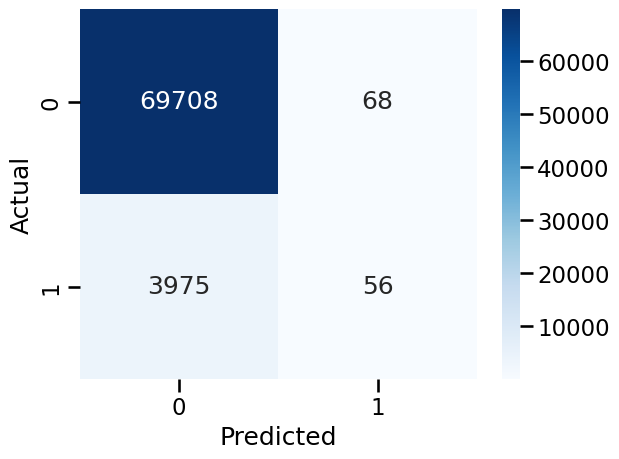

In [30]:
# Confusion matrix for Logistic Regression 
sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred_lr)
ax = sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel('Actual')
plt.show()


In [31]:
# Access the Logistic Regression classifier from the pipeline
lr_model = pipeline_lr.named_steps['classifier']

# Get the feature names from the preprocessor
feature_names = pipeline_lr.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out()
cat_feature_names = pipeline_lr.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out()
all_feature_names = np.concatenate([feature_names, cat_feature_names])

# Get the coefficients
coefficients = lr_model.coef_[0]

# Create a DataFrame for visualization
coef_df = pd.DataFrame({'Feature': all_feature_names, 'Coefficient': coefficients})
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

# Print the coefficients
print("Logistic Regression Coefficients:")
# Get the top 5 positive coefficients
top_positive = coef_df.head(5)

# Get the top 5 negative coefficients
top_negative = coef_df.tail(5)

# Print the results
print("Top 5 Positive Coefficients:")
print(top_positive)

print("\nTop 5 Negative Coefficients:")
print(top_negative)

Logistic Regression Coefficients:
Top 5 Positive Coefficients:
                        Feature  Coefficient
80  AgeCategory_Age 80 or older     2.788887
79     AgeCategory_Age 75 to 79     2.501989
78     AgeCategory_Age 70 to 74     2.298714
77     AgeCategory_Age 65 to 69     2.111281
60           GeneralHealth_Poor     1.953265

Top 5 Negative Coefficients:
                       Feature  Coefficient
67  SmokerStatus_Former smoker    -0.328071
15                State_Hawaii    -0.341338
69    AgeCategory_Age 25 to 29    -0.372790
51        State_Virgin Islands    -0.377499
68   SmokerStatus_Never smoked    -0.675646


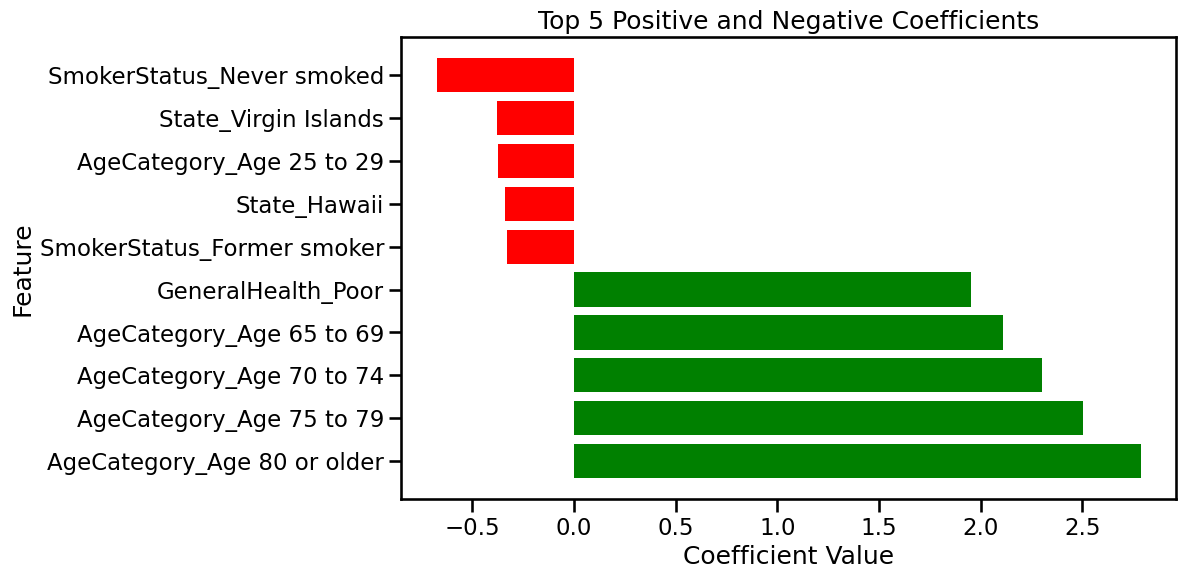

In [34]:
import matplotlib.pyplot as plt

# Combine the top 5 positive and top 5 negative coefficients into a single DataFrame
top_features = pd.concat([top_positive, top_negative])

# Plot the coefficients
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Coefficient'], color=['green' if x > 0 else 'red' for x in top_features['Coefficient']])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Top 5 Positive and Negative Coefficients')
plt.show()


In [56]:
#Random Forest Classifier
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Hyperparameter grid
param_grid_rf = {
    'classifier__n_estimators': [50, 100]
}

# Use GridSearchCV for hyperparameter tuning
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# Get the best model
best_rf = grid_search_rf.best_estimator_

# Predictions 
y_pred_rf = best_rf.predict(X_test)


# Model Evaluation 
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

# Performance metrics
print(f"Random Forest - Accuracy: {accuracy_rf:.2f}, Precision: {precision_rf:.2f}, Recall: {recall_rf:.2f}, F1-score: {f1_rf:.2f}")


Random Forest - Accuracy: 0.94, Precision: 0.29, Recall: 0.01, F1-score: 0.02


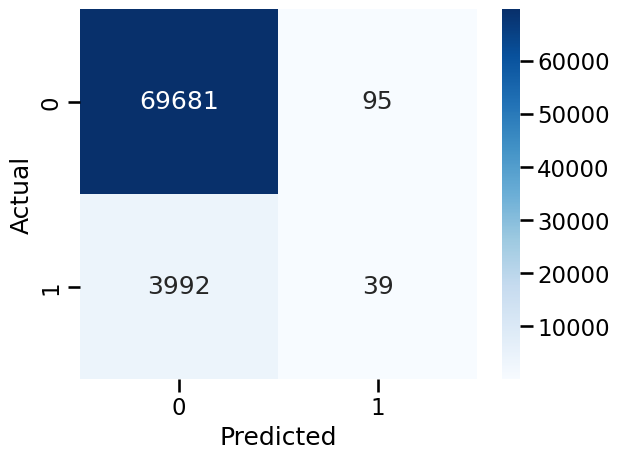

In [57]:
# Confusion matrix for Random Forest
sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred_rf)
ax = sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel('Actual')
plt.show()


In [58]:
# XGBoost 
pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

# Define the hyperparameter grid
param_grid_xgb = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 6, 9],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0]
}

# Use GridSearchCV for hyperparameter tuning
grid_search_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

# Get the best model
best_xgb = grid_search_xgb.best_estimator_

# Predict and evaluate the XGBoost model
y_pred_xgb = best_xgb.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)

# Print the performance metrics
print(f"XGBoost - Accuracy: {accuracy_xgb:.2f}, Precision: {precision_xgb:.2f}, Recall: {recall_xgb:.2f}, F1-score: {f1_xgb:.2f}")


XGBoost - Accuracy: 0.95, Precision: 0.44, Recall: 0.01, F1-score: 0.02


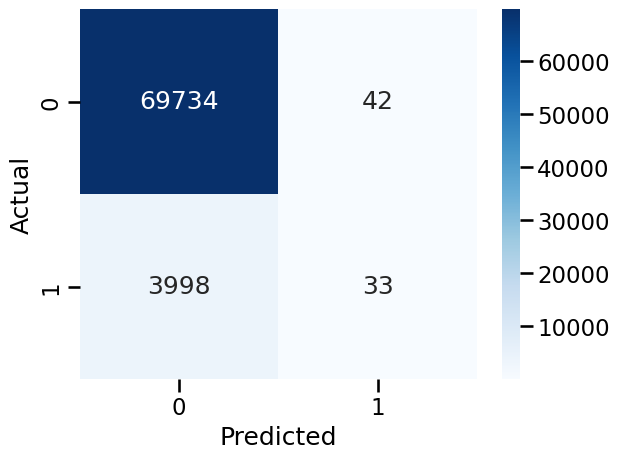

In [59]:
# Confusion matrix for XGBoost
sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred_xgb)
ax = sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel('Actual')
plt.show()
